In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import the libraries

In [ ]:
!pip install annoy

In [ ]:
import os
import multiprocessing
import pandas as pd
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from annoy import AnnoyIndex
import numpy as np
import collections
import json



#EDA

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/20222/Khai phá web/Data/events.csv')
data = data.drop(["transactionid"], axis=1) #drop unused columns
data.head()

,timestamp,visitorid,event,itemid
0,1433221332117,257597,view,355908
1,1433224214164,992329,view,248676
2,1433221999827,111016,view,318965
3,1433221955914,483717,view,253185
4,1433221337106,951259,view,367447


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   visitorid  int64 
 2   event      object
 3   itemid     int64 
dtypes: int64(3), object(1)
memory usage: 84.1+ MB


In [ ]:
# count missing values in each columns
data.isnull().sum()

timestamp    0
visitorid    0
event        0
itemid       0
dtype: int64

In [ ]:
data.event.value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In [ ]:
visitorid_count = data['visitorid'].nunique()
visitorid_count

1407580

In [ ]:
itemid_count = data['itemid'].nunique()
itemid_count

235061

In [ ]:
# remove duplicates if any. (all columns' values are idential)
print('Number of rows before removing duplicates: ', data.shape[0])
msk=data.duplicated()
data=data[~msk]
data.reset_index(drop=True, inplace=True)
print('Number of rows after removing duplicates: ', data.shape[0])

Number of rows before removing duplicates:  2756101
Number of rows after removing duplicates:  2755641


In [ ]:
# convert unix timestamp to readable dates (GMT)te
# separate the 'ordinary' timestamp and the milliseconds
list=[]
for i, unix in enumerate(data['timestamp']):
    timestamp, ms = divmod(unix, 1000)

    # create the datetime from the timestamp
    # add the milliseconds separately
    dt = datetime.datetime.fromtimestamp(timestamp) + datetime.timedelta(milliseconds=ms)

    formatted_time = dt.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]
    list.append(formatted_time)

data['date_time']=pd.DataFrame({'date_time':list})
data.head()

,timestamp,visitorid,event,itemid,date_time
0,1433221332117,257597,view,355908,2015-06-02 05:02:12.117
1,1433224214164,992329,view,248676,2015-06-02 05:50:14.164
2,1433221999827,111016,view,318965,2015-06-02 05:13:19.827
3,1433221955914,483717,view,253185,2015-06-02 05:12:35.914
4,1433221337106,951259,view,367447,2015-06-02 05:02:17.106


In [ ]:
print('Start Date of Dataset: ', data['date_time'].min())
print('End Date of Dataset: ', data['date_time'].max())

Start Date of Dataset:  2015-05-03 03:00:04.384
End Date of Dataset:  2015-09-18 02:59:47.788


This dataset is recorded from 3rd May, 2015 to 18th September, 2015 (GMT)

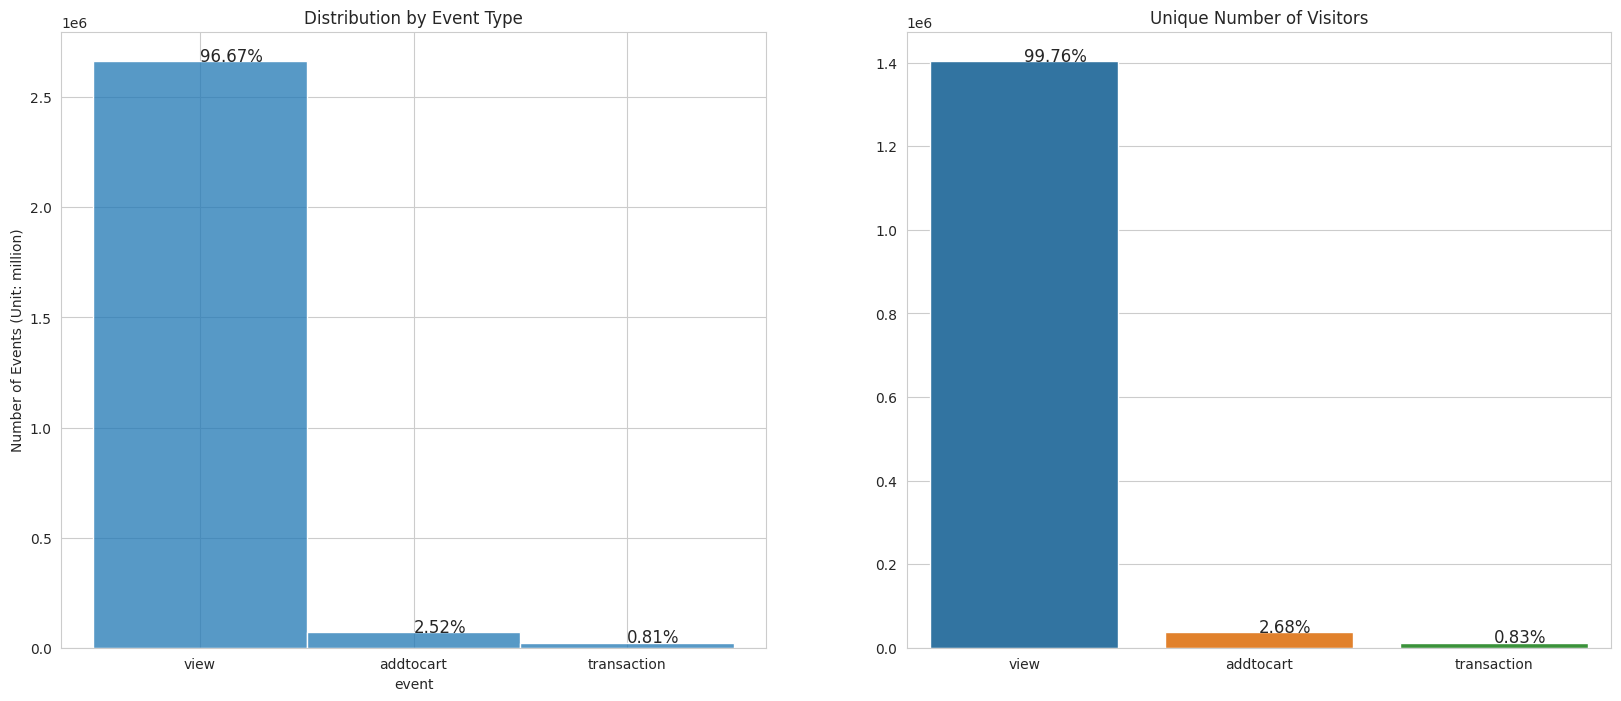

In [ ]:
# distribution by event
# plot
totalcases=data.shape[0]
sns.set_style('whitegrid')

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,8))
sns.histplot(x = 'event', data = data, bins = 3, ax = ax1)
ax1.set_ylabel('Number of Events (Unit: million)')
ax1.set_title('Distribution by Event Type')
for x, counts in zip(data['event'].unique().tolist(), data['event'].value_counts().tolist()):
    text=str(round((counts/totalcases)*100,2)) +'%'
    ax1.text(x, counts, text, fontsize=12)

# unique number of visitors by event
events = data['event'].unique().tolist()
unique_num = []
ratios = []
for event in events:
    uni_visit = len(data['visitorid'][data['event']==event].unique())
    unique_num.append(uni_visit)
    ratios.append(uni_visit/len(set(data['visitorid'])))

sns.barplot(x = events, y = unique_num, ax = ax2)

ratio_p = [str(round(r*100,2)) + '%' for r in ratios]
for e, c, r in zip(range(3), unique_num, ratio_p):
    ax2.text(e, c, r, fontsize=12)

ax2.set_title('Unique Number of Visitors')
plt.show()

When analysing the distribution of events, 'View' occupies 96.67%, 'Add to cart' 2.52%, 'Transaction' 0.81%.

The number of unique visitors was around the half of total number in all three types of event, for example, total view is 2.6 million, but unique visitor for the views is the half, which means that on average one visitor caused 2 actions.

In [ ]:
action_counts = data.groupby('visitorid')['event'].count()
df = action_counts.reset_index()
df.columns = ['visistorid', 'action_count']
df

,visistorid,action_count
0,0,3
1,1,1
2,2,8
3,3,1
4,4,1
...,...,...
1407575,1407575,1
1407576,1407576,1
1407577,1407577,1
1407578,1407578,1


#Load data

In [ ]:
train = pd.read_json('/content/drive/MyDrive/20222/Khai phá web/Data/train_sessions.jsonl', lines=True)
test = pd.read_json('/content/drive/MyDrive/20222/Khai phá web/Data/test_sessions.jsonl', lines=True)
test_labels = pd.read_json('/content/drive/MyDrive/20222/Khai phá web/Data/test_labels.jsonl', lines=True)

In [ ]:
train

,Unnamed: 0,visitorid,events
0,2,2,"[{'itemid': 325215, 'timestamp': 1438969904567..."
1,6,6,"[{'itemid': 65273, 'timestamp': 1440914628202,..."
2,7,7,"[{'itemid': 139394, 'timestamp': 1431581976753..."
3,13,13,"[{'itemid': 320589, 'timestamp': 1434602542103..."
4,22,22,"[{'itemid': 86411, 'timestamp': 1435878975173,..."
...,...,...,...
388449,7537,1407537,"[{'itemid': 156770, 'timestamp': 1437503740977..."
388450,7560,1407560,"[{'itemid': 240708, 'timestamp': 1436072303991..."
388451,7567,1407567,"[{'itemid': 183650, 'timestamp': 1439232086229..."
388452,7572,1407572,"[{'itemid': 122041, 'timestamp': 1431311689814..."


In [ ]:
train = train.drop(["Unnamed: 0"], axis=1)
train

,visitorid,events
0,2,"[{'itemid': 325215, 'timestamp': 1438969904567..."
1,6,"[{'itemid': 65273, 'timestamp': 1440914628202,..."
2,7,"[{'itemid': 139394, 'timestamp': 1431581976753..."
3,13,"[{'itemid': 320589, 'timestamp': 1434602542103..."
4,22,"[{'itemid': 86411, 'timestamp': 1435878975173,..."
...,...,...
388449,1407537,"[{'itemid': 156770, 'timestamp': 1437503740977..."
388450,1407560,"[{'itemid': 240708, 'timestamp': 1436072303991..."
388451,1407567,"[{'itemid': 183650, 'timestamp': 1439232086229..."
388452,1407572,"[{'itemid': 122041, 'timestamp': 1431311689814..."


In [ ]:
test

,visitorid,events
0,0,"[{'itemid': 285930, 'timestamp': 1442004589439..."
1,54,"[{'itemid': 388096, 'timestamp': 1442338531705..."
2,86,"[{'itemid': 150060, 'timestamp': 1442347760317..."
3,88,"[{'itemid': 58827, 'timestamp': 1442086733371,..."
4,177,"[{'itemid': 6073, 'timestamp': 1442290140204, ..."
...,...,...
12602,1406977,"[{'itemid': 360704, 'timestamp': 1442284246171..."
12603,1406985,"[{'itemid': 425477, 'timestamp': 1441946380260..."
12604,1407056,"[{'itemid': 215715, 'timestamp': 1442184431823..."
12605,1407422,"[{'itemid': 354153, 'timestamp': 1442118966867..."


In [ ]:
test_labels

,visitorid,labels
0,0,{'view': 67045}
1,54,{'view': 319680}
2,86,{'view': 150060}
3,88,{'view': 420028}
4,177,{'view': 6073}
...,...,...
12602,1406977,{'view': 276163}
12603,1406985,{'view': 103922}
12604,1407056,{'view': 79572}
12605,1407422,{'view': 354153}


#Create sentences training

In [ ]:
# Create training sentences
train['itemid_list'] = train['events'].apply(lambda x: [event['itemid'] for event in x])
train.head()

,visitorid,events,itemid_list
0,2,"[{'itemid': 325215, 'timestamp': 1438969904567...","[325215, 325215, 259884, 216305, 342816, 34281..."
1,6,"[{'itemid': 65273, 'timestamp': 1440914628202,...","[65273, 253615, 344723, 344723, 344723, 344723]"
2,7,"[{'itemid': 139394, 'timestamp': 1431581976753...","[139394, 164941, 226353]"
3,13,"[{'itemid': 320589, 'timestamp': 1434602542103...","[320589, 278689]"
4,22,"[{'itemid': 86411, 'timestamp': 1435878975173,...","[86411, 86411]"


In [ ]:
sentences = train['itemid_list'].tolist()

#Training

In [ ]:
%%time
model = Word2Vec(
    sentences=sentences,
    window=5,
    vector_size=200,
    alpha=0.05,
    min_alpha=0.0001,
    min_count=1,
    negative=20,
    workers=multiprocessing.cpu_count() - 1
)
model.save("word2vec.model")

CPU times: user 3min 40s, sys: 1.38 s, total: 3min 41s
Wall time: 3min 48s


#Prepare test data

In [ ]:
test['labels'] = test['events'].apply(lambda x: [event['itemid'] for event in x])
test.head()

,visitorid,events,labels
0,0,"[{'itemid': 285930, 'timestamp': 1442004589439...","[285930, 357564]"
1,54,"[{'itemid': 388096, 'timestamp': 1442338531705...","[388096, 283115, 38965]"
2,86,"[{'itemid': 150060, 'timestamp': 1442347760317...",[150060]
3,88,"[{'itemid': 58827, 'timestamp': 1442086733371,...",[58827]
4,177,"[{'itemid': 6073, 'timestamp': 1442290140204, ...","[6073, 6073]"


In [ ]:
test['labels_view'] = test['events'].apply(lambda x: [event['itemid'] for event in x if event['event'] == 'view'])
test['labels_addtocart'] = test['events'].apply(lambda x: [event['itemid'] for event in x if event['event'] == 'addtocart'])
test['labels_transaction'] = test['events'].apply(lambda x: [event['itemid'] for event in x if event['event'] == 'transaction'])
test.head()

,visitorid,events,labels,labels_view,labels_addtocart,labels_transaction
0,0,"[{'itemid': 285930, 'timestamp': 1442004589439...","[285930, 357564]","[285930, 357564]",[],[]
1,54,"[{'itemid': 388096, 'timestamp': 1442338531705...","[388096, 283115, 38965]","[388096, 283115, 38965]",[],[]
2,86,"[{'itemid': 150060, 'timestamp': 1442347760317...",[150060],[150060],[],[]
3,88,"[{'itemid': 58827, 'timestamp': 1442086733371,...",[58827],[58827],[],[]
4,177,"[{'itemid': 6073, 'timestamp': 1442290140204, ...","[6073, 6073]",[6073],[6073],[]


#Inferrence

In [ ]:
pred_test_df = pd.DataFrame()

In [ ]:
pred_test_df['visitorid']=test['visitorid']
pred_test_df['labels']=test['labels']
pred_test_df.head()

,visitorid,labels
0,0,"[285930, 357564]"
1,54,"[388096, 283115, 38965]"
2,86,[150060]
3,88,[58827]
4,177,"[6073, 6073]"


In [ ]:
model = Word2Vec.load("word2vec.model")
aid2idx = {
    aid: idx for idx, aid in enumerate(model.wv.index_to_key)
}
index = AnnoyIndex(200, 'angular')
for aid, idx in aid2idx.items():
    index.add_item(aid, model.wv.vectors[idx])
index.build(50)

def generate_candidate(aid_visited, num):
    aid_visited = aid_visited[-20:]
    if num > 19:
        num = 19
    if len(aid_visited) >= num:
        y = []
        y_sum = list(np.zeros(21-len(aid_visited)))
        for i in range(num):
            y.append(list(index.get_nns_by_item(aid_visited[-(i+1)], 21 - len(aid_visited))[1:]))
            y_sum += y[-1]
        counter = dict(collections.Counter(y_sum))
        res = sorted(list(set(y_sum)), key = lambda d: counter[d], reverse=True)
    else:
        res = list(index.get_nns_by_item(aid_visited[-1], 21 - len(aid_visited))[1:])

    aid_visited = list(aid_visited) + list(res)[1:21-len(aid_visited)]
    return aid_visited
pred_test_df['labels'] = pred_test_df.labels.apply(lambda x: list(set(x)))
pred_test_df['labels'] = pred_test_df.labels.apply(lambda x: generate_candidate(x, len(x)))
pred_test_df['labels'] = pred_test_df.labels.apply(lambda x: " ".join(map(str,x)))

clicks_pred_df = pred_test_df.copy()
clicks_pred_df.visitorid = clicks_pred_df.visitorid.apply(lambda x: str(x) + '_view')
orders_pred_df = pred_test_df.copy()
orders_pred_df.visitorid = orders_pred_df.visitorid.apply(lambda x: str(x) + '_transaction')
carts_pred_df = pred_test_df.copy()
carts_pred_df.visitorid = carts_pred_df.visitorid.apply(lambda x: str(x) + '_addtocart')
pred_df = pd.concat(
    [clicks_pred_df, orders_pred_df, carts_pred_df]
)
pred_df.columns = ['session_type', 'labels']
pred_df = pred_df.sort_values(by='session_type').reset_index()
pred_df = pred_df.drop('index', axis=1)

In [ ]:
pred_df

,session_type,labels
0,0_addtocart,285930 357564 146572 393744 6162 111897 379693...
1,0_transaction,285930 357564 146572 393744 6162 111897 379693...
2,0_view,285930 357564 146572 393744 6162 111897 379693...
3,1000253_addtocart,328692 28805 307987 116261 286123 315950 16351...
4,1000253_transaction,328692 28805 307987 116261 286123 315950 16351...
...,...,...
37816,999765_transaction,208930 136599 382932 305793 246784 125827 2785...
37817,999765_view,208930 136599 382932 305793 246784 125827 2785...
37818,999835_addtocart,186256 318336 227217 40596 282282 387371 42808...
37819,999835_transaction,186256 318336 227217 40596 282282 387371 42808...


In [ ]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37821 entries, 0 to 37820
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   session_type  37821 non-null  object
 1   labels        37821 non-null  object
dtypes: object(2)
memory usage: 591.1+ KB


In [ ]:
pred_df.to_csv("/content/drive/MyDrive/20222/Khai phá web/Data/submit.csv", index=False)

#Compute

In [ ]:
import argparse
import json
import logging
from pathlib import Path

from tqdm.auto import tqdm


def prepare_predictions(predictions: list[str]):
    prepared_predictions = dict()
    for prediction in tqdm(predictions, desc="Preparing predictions"):
        sid_type, preds = prediction.strip().split(",")
        sid, event_type = sid_type.split("_")
        preds = [int(float(aid)) for aid in preds.split(" ")] if preds != "" else []
        if not int(sid) in prepared_predictions:
            prepared_predictions[int(sid)] = dict()
        prepared_predictions[int(sid)][event_type] = preds
    return prepared_predictions


def prepare_labels(labels: list[str]):
    final_labels = dict()
    for label in tqdm(labels, desc="Preparing labels"):
        label = json.loads(label)
        final_labels[label["visitorid"]] = {
            "view": label["labels"].get("view", None),
            'addtocart': set(label["labels"].get('addtocart', [])),
            'transaction': set(label["labels"].get('transaction', []))
        }
    return final_labels


def evaluate_session(labels: dict, prediction: dict, k: int):
    if 'view' in labels and labels['view'] and 'view' in prediction and prediction['view']:
        clicks_hit = float(labels['view'] in prediction['view'][:k])
    else:
        clicks_hit = None

    if 'addtocart' in labels and labels['addtocart'] and 'addtocart' in prediction and prediction['addtocart']:
        cart_hits = len(set(prediction['addtocart'][:k]).intersection(labels['addtocart']))
    else:
        cart_hits = None

    if 'transaction' in labels and labels['transaction'] and 'transaction' in prediction and prediction['transaction']:
        order_hits = len(set(prediction['transaction'][:k]).intersection(labels['transaction']))
    else:
        order_hits = None

    return {'view': clicks_hit, 'addtocart': cart_hits, 'transaction': order_hits}


def evaluate_sessions(labels: dict[str, dict], predictions: dict[int, dict], k: int):
    result = {}
    for session_id, session_labels in tqdm(labels.items(), desc="Evaluating sessions"):
        if session_id in predictions:
            result[session_id] = evaluate_session(session_labels, predictions[session_id], k)
        else:
            result[session_id] = {k: 0. if v else None for k, v in session_labels.items()}
    return result


def num_events(labels: dict[int, dict], k: int):
    num_clicks = 0
    num_carts = 0
    num_orders = 0
    for event in labels.values():
        if 'view' in event and event['view']:
            num_clicks += 1
        if 'addtocart' in event and event['addtocart']:
            num_carts += min(len(event['addtocart']), k)
        if 'transaction' in event and event['transaction']:
            num_orders += min(len(event['transaction']), k)
    return {'view': num_clicks, 'addtocart': num_carts, 'transaction': num_orders}


def recall_by_event_type(evalutated_events: dict, total_number_events: dict):
    clicks = 0
    carts = 0
    orders = 0
    for event in evalutated_events.values():
        if 'view' in event and event['view']:
            clicks += event['view']
        if 'addtocart' in event and event['addtocart']:
            carts += event['addtocart']
        if 'transaction' in event and event['transaction']:
            orders += event['transaction']

    return {
        'view': clicks / total_number_events['view'],
        'addtocart': carts / total_number_events['addtocart'],
        'transaction': orders / total_number_events['transaction']
    }


def weighted_recalls(recalls: dict, weights: dict):
    result = 0.0
    for event, recall in recalls.items():
        result += recall * weights[event]
    return result


def get_scores(labels: dict[int, dict],
               predictions: dict[int, dict],
               k=20,
               weights={
                   'view': 0.10,
                   'addtocart': 0.30,
                   'transaction': 0.60
               }):
    '''
    Calculates the weighted recall for the given predictions and labels.
    Args:
        labels: dict of labels for each session
        predictions: dict of predictions for each session
        k: cutoff for the recall calculation
        weights: weights for the different event types
    Returns:
        recalls for each event type and the weighted recall
    '''
    total_number_events = num_events(labels, k)
    evaluated_events = evaluate_sessions(labels, predictions, k)
    recalls = recall_by_event_type(evaluated_events, total_number_events)
    recalls["total"] = weighted_recalls(recalls, weights)
    return recalls

In [ ]:
labels_path = '/content/drive/MyDrive/20222/Khai phá web/Data/test_labels.jsonl'
predictions_path = '/content/drive/MyDrive/20222/Khai phá web/Data/submit.csv'

In [ ]:
with open(labels_path, "r") as f:
    logging.info(f"Reading labels from {labels_path}")
    labels = f.readlines()
    labels = prepare_labels(labels)
    logging.info(f"Read {len(labels)} labels")
with open(predictions_path, "r") as f:
    logging.info(f"Reading predictions from {predictions_path}")
    predictions = f.readlines()[1:]
    predictions = prepare_predictions(predictions)
    logging.info(f"Read {len(predictions)} predictions")
logging.info("Calculating scores")
scores = get_scores(labels, predictions)
logging.info(f"Scores: {scores}")

Preparing labels:   0%|          | 0/12607 [00:00<?, ?it/s]

Preparing predictions:   0%|          | 0/37821 [00:00<?, ?it/s]

Evaluating sessions:   0%|          | 0/12607 [00:00<?, ?it/s]

In [ ]:
scores

{'view': 0.44564678671733027,
 'addtocart': 0.6021934197407777,
 'transaction': 0.8066298342541437,
 'total': 0.7092006051464526}